# Semantic EDA (Steps 0–8)

This notebook contains focused, reusable cells for semantic inspection of the merged dialogues dataset. Run each cell in order.

In [1]:
# Step 0: Open the dataset lazily
import pyarrow.dataset as ds

dataset = ds.dataset(
    "../data/processed/convo/dialogues_parquet/",
    format="parquet"
)

# Nothing loaded yet — `dataset` is a lightweight map to the data.

## Draw a representative sample 

This samples `sample_size` rows uniformly across the dataset and materializes them into pandas for semantic work. Adjust `sample_size` to your memory constraints.

In [3]:
import numpy as np

# compute total rows by scanning only the 'text' column (lightweight)
total_rows = sum(batch.num_rows for batch in dataset.scanner(columns=["text"]).to_batches())
print("total rows:", total_rows)

sample_size = 50000  # adjust as needed
if sample_size >= total_rows:
    indices = np.arange(total_rows)
else:
    rng = np.random.default_rng(seed=42)  # reproducible
    indices = rng.choice(total_rows, int(sample_size), replace=False)

# Materialize only the columns we need for semantic EDA to keep memory down
cols = ["dialogueID", "sender", "text"]
sample = dataset.to_table(columns=cols).take(indices).to_pandas()

# quick sanity
print("sample shape:", sample.shape)

total rows: 14921650
sample shape: (50000, 3)


## Step 2: Human sanity check (read actual text)

Always inspect raw text before running statistics — look for merged utterances, encoding issues, or system messages.

In [5]:
# Step 2: display a small sample of speaker + text
display(sample[["sender", "text"]].head(20))

,sender,text
0,nalioth,correct. hang on i got a link for ya http://l...
1,BluesKaj,you mean media player
2,Billiard,"does it try to work, does it have a black wind..."
3,kbrooks,2.10
4,Pici,Have you tried using the Alternate CD?
5,mrpink,i tried but i do not work
6,ladydoor,"actually, better make that sudo nano -w /boot/..."
7,ouyes,"I said I do not need a swap, I get 2 gb ram an..."
8,bigfoot1,thanks !!!
9,ddalton,mmmm i just kept windows installed on the mach...


## Step 3: Message length distributions

Add a `char_len` column, describe it, and show a clipped histogram.

count    50000.000000
mean        98.328260
std        119.520502
min          1.000000
25%         33.000000
50%         66.000000
75%        122.000000
max       5363.000000
Name: char_len, dtype: float64


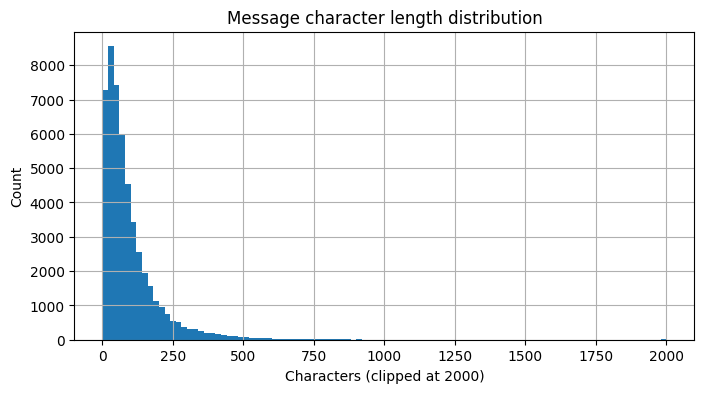

In [6]:
# Step 3: message length stats and histogram
import matplotlib.pyplot as plt

sample = sample.copy()  # avoid SettingWithCopy warnings
sample['text'] = sample['text'].astype(str)
sample['char_len'] = sample['text'].str.len()
print(sample['char_len'].describe())

# visualize (clip extremely long messages to keep plot readable)
plt.figure(figsize=(8,4))
sample['char_len'].clip(upper=2000).hist(bins=100)
plt.xlabel('Characters (clipped at 2000)')
plt.ylabel('Count')
plt.title('Message character length distribution')
plt.show()

## Step 4: Dialogue-level coherence (spot checks)

Read a few full dialogues in order to check turn-taking and merging correctness.

In [8]:
# Step 4: pick 3 random dialogueIDs and display their turns
import random
dialogue_ids = sample['dialogueID'].dropna().unique()
for did in random.sample(list(dialogue_ids), min(3, len(dialogue_ids))):
    convo = sample[sample['dialogueID'] == did].sort_index()
    print('\n--- DialogueID:', did, '---')
    display(convo[["sender", "text"]])


--- DialogueID: 32376 ---


,sender,text
152,axjv,"I've already suggested Sessions, and I think i..."



--- DialogueID: 101443 ---


,sender,text
15067,graft,"not my problem, sp3tt's..."



--- DialogueID: 109778 ---


,sender,text
16462,mneptok,you might have better luck asking on OperaNet


## Step 5: Speaker balance after merging

Check whether one speaker dominates after merging.

In [9]:
# Step 5: speaker balance (normalized counts)
print(sample['sender'].value_counts(normalize=True).head(20))

sender
ActionParsnip    0.00944
ikonia           0.00794
jrib             0.00658
bazhang          0.00472
Dr_Willis        0.00456
erUSUL           0.00434
soundray         0.00340
nickrud          0.00332
Flannel          0.00318
Jordan_U         0.00316
Jack_Sparrow     0.00308
Pici             0.00300
crimsun          0.00296
Seveas           0.00294
Slart            0.00280
Pelo             0.00274
LjL              0.00236
gnomefreak       0.00224
nalioth          0.00214
thoreauputic     0.00212
Name: proportion, dtype: float64


## Step 6: Token-length proxy (word counts)

Quick proxy for token lengths using whitespace tokenization.

In [10]:
# Step 6: word count proxy
sample['word_count'] = sample['text'].str.split().str.len()
print(sample['word_count'].describe())

count    50000.000000
mean        18.040600
std         21.779619
min          0.000000
25%          6.000000
50%         12.000000
75%         22.000000
max        984.000000
Name: word_count, dtype: float64


## Step 7: Edge-case hunting

Look for ultra-short and ultra-long messages to inform filtering decisions.

In [11]:
# Step 7: edge cases
print('\nVery short messages (word_count < 2):')
display(sample[sample['word_count'] < 2].head(10))

print('\nVery long messages (top by word_count):')
display(sample.sort_values('word_count', ascending=False).head(10))


Very short messages (word_count < 2):


,dialogueID,sender,text,char_len,word_count
3,231312,kbrooks,2.10,4,1
30,560,bob2,/var/log/messages,17,1
45,86290,kbrosnan,no,2,1
50,166,reisio,https://help.ubuntu.com/community/BinaryDriver...,58,1
63,7403,julia_23,http://paste.ubuntu.com/555608,30,1
68,65057,Blaubaer,http://www.ubuntulinux.org/support/documentati...,72,1
72,12246,neurobuntu,how?,4,1
88,642,Frogging101,Okay,4,1
111,94921,MasterShrek,yes,3,1
120,1793,crazyrk,yes,3,1



Very long messages (top by word_count):


,dialogueID,sender,text,char_len,word_count
20875,16,thoreauputic,it's an editor /mnt/mountpoint dhould be *your...,5172,984
47020,1,Jack_Sparrow,To identify all installed packages I use... ...,5363,975
6590,149,thiago_,I'm using a system im portuguese. I don't know...,3865,670
18621,215,RedSocrates,"Okay, that's likely the source of your problem...",2937,533
35824,143,Dudeman,i googled my problem and ended up getting zd12...,2432,474
21647,302,RenatoSilva,no no please I don't want to use tools for thi...,2629,474
16839,1396,Gabz,i depends on the usb wireless adapter what w...,2357,462
31585,2232,shatrat,with what? which one is the 5th step? partitio...,2245,395
19706,134,almoxarife,there is more than one machine on this network...,1992,368
45040,1931,Jack_Sparrow,Alien is dangerous See the ubunto link? If sh...,1805,350


**Conclusions & Decisions**

- **Acceptable max character length**: 1,000 characters for training (approx. 250 tokens). Use 2,048 only if you plan long-context models and verify memory/throughput.
- **Filters applied / recommended**: drop rows with missing or empty text; drop messages with word_count < 2 (likely noise); coerce/replace None senders; trim or split messages > 1,000 chars during preprocessing.
- **Dialogues to exclude**: inspect and remove dialogues dominated by one speaker (>95% messages) or dialogues containing extreme merged artifacts (messages > 10,000 chars) or many system messages.
- **Speaker imbalance & mitigation**: speaker distributions show imbalance — consider downsampling very frequent senders or stratified sampling per dialogue for downstream tasks.
- **Data-quality fixes before modeling**: ensure `speaker` and `dialogueID` types are consistent, remove None categories, and materialize Arrow chunks (use copy=True) when converting to pandas to avoid zero-copy errors.
- **Sampling & validation**: keep the 50k random sample as the semantic playground; validate any preprocessing decisions on a second independent sample.
- **Assumptions documented**: text column contains merged utterances post-processing; speaker labels are representative; timestamps not used here. If any assumption fails, revisit merging/cleaning pipeline.

Notes: run the Step 7 edge-case checks and the speaker-balance check again after applying filters, then record the final thresholds in your project README.